In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import tensorflow as tf
import time
import scipy

import collections, numpy

import data_loader as dl
import data_transformer as dt

from sklearn.cluster import KMeans
from keras.utils import to_categorical

# helper for setting up the bidirectional, multilayer lstm
def bidirectional_lstm(input_data, num_layers, rnn_size, keep_prob, lengths=None):
    output = input_data
    for layer in range(num_layers):
        with tf.variable_scope('encoder_{}'.format(layer),reuse=tf.AUTO_REUSE):

            cell_fw = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.truncated_normal_initializer(-0.1, 0.1, seed=2))
            cell_fw = tf.contrib.rnn.DropoutWrapper(cell_fw, input_keep_prob = keep_prob)

            cell_bw = tf.contrib.rnn.LSTMCell(rnn_size, initializer=tf.truncated_normal_initializer(-0.1, 0.1, seed=2))
            cell_bw = tf.contrib.rnn.DropoutWrapper(cell_bw, input_keep_prob = keep_prob)

            outputs, states = tf.nn.bidirectional_dynamic_rnn(cell_fw, 
                                                              cell_bw, 
                                                              output,
                                                              dtype=tf.float32,
                                                              sequence_length=lengths)
            output = tf.concat(outputs,2)

    return output

In [3]:
# change this path to match the path of where you have the
# training_50 and validation files
txt_data_path = '/home/mikey/Data/ProteinNet/casp7_txt/'

The data_lim is important because so far the full 13000 proteins crashes my system with 16Gb of ram

Load training data

In [124]:
file_name = 'training_50'
data_lim = 2000
prim_train, evo_train, dih_train, mask_train = (dl.parse_primary_from_file(txt_data_path + file_name, data_lim), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name, data_lim),
                                                dl.load_file('./'+file_name+'_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name, data_lim))
dih_train = dih_train[:data_lim]
len(prim_train), prim_train[0].shape, len(evo_train), evo_train[0].shape, len(dih_train), dih_train[0].shape, len(mask_train), mask_train[0].shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|██████████| 2000/2000 [00:00<00:00, 68959.18it/s]


Grouped 21's together
Loaded data and filtered line endings
Extracted mask data


(2000, (70, 20), 2000, (70, 21), 2000, (70, 3), 2000, (70,))

Load validation data

In [125]:
file_name = 'validation'
prim_valid, evo_valid, dih_valid, mask_valid = (dl.parse_primary_from_file(txt_data_path + file_name), 
                                                dl.parse_evolutionary_from_file(txt_data_path + file_name),
                                                dl.load_file('./'+ file_name + '_dih.joblib'),
                                                dl.parse_mask_from_file(txt_data_path + file_name))
len(prim_valid), prim_valid[0].shape, len(evo_valid), evo_valid[0].shape, len(dih_valid), dih_valid[0].shape, len(mask_valid), mask_valid[0].shape

Loaded data and filtered line endings
Extracted primary data
Encoded primary sequences
Loaded data and filtered line endings
Extracted evolutionary data


100%|██████████| 224/224 [00:00<00:00, 64267.33it/s]

Grouped 21's together
Loaded data and filtered line endings
Extracted mask data


(224, (269, 20), 224, (269, 21), 224, (269, 3), 224, (269,))

Pad the data and limit protein length. Prepare the data for training

In [126]:
max_len = 500
n_angles = 2 # 3 if all, 2 if only phi and psi

prim_, evo_, dih_, mask_ = dt.limit_length_and_pad(prim_train, evo_train, dih_train, mask_train, max_len)
x_train, y_train = np.concatenate([prim_, evo_], axis=2), dih_[:,:,:n_angles]
prim_v, evo_v, dih_v, mask_v = dt.limit_length_and_pad(prim_valid, evo_valid, dih_valid, mask_valid, max_len)
x_valid, y_valid = np.concatenate([prim_v, evo_v], axis=2), dih_v[:,:,:n_angles]

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

padded
(1892,) (70, 20)
padded
(1892,) (70, 21)
padded
(1892,) (70, 3)
padded
(1892,) (70, 1)
padded
(213,) (269, 20)
padded
(213,) (269, 21)
padded
(213,) (269, 3)
padded
(213,) (269, 1)


((1892, 500, 41), (1892, 500, 2), (213, 500, 41), (213, 500, 2))

In [134]:
def manual_clusters(n_clusters):
    # these manually selecteed clusters will be chosen from left to right
    # when n_clusters < man_clusters.shape[0]
    man_clusters = np.array([[-1.5, 0, 0], [-1.5, 2.5, 0], [1.5, 0.5, 0], [-2.2, -2.5, 0],
                          [-1.5, 0, np.pi], [-1.5, 0, -np.pi], [-1.5, 2.5, np.pi], [-1.5, 2.5, -np.pi],
                            [0,0,0],[0,0,0]])
    try:
        return {
            i+1: man_clusters[:i+1] for i in range(man_clusters.shape[0])
        }[n_clusters]
    except KeyError as e:
        print("Manual clusters only support max", man_clusters.shape[0])
        print(e)
        raise

def kmeans_clusters(angles, limit_data, filter_, n_clusters):
    """
        angles: [..., ..., 3]
        limit_data: int, how many protein to consider for clustering
        filter_: bool, deciding if clusters too close to each other should be merged
    """
    def dist2(p1, p2):
        return np.sum((p1-p2)**2)

    def fuse(points, min_dist):
        ret = []
        d2 = min_dist * min_dist
        n = len(points)
        taken = [False] * n
        for i in range(n):
            if not taken[i]:
                count = 1
                point = points[i]
                taken[i] = True
                for j in range(i+1, n):
                    if dist2(points[i], points[j]) < d2:
                        point += points[j]
                        count+=1
                        taken[j] = True
                point /= count
                ret.append(point)
        return np.array(ret)
    
    print("Fitting KMeans...")
    km = KMeans(n_clusters=n_clusters, random_state=0, verbose=0, max_iter=1000).fit(angles[:limit_data].reshape(-1,n_angles))
    print("Done")
    if filter_:
        return fuse(km.cluster_centers_, min_dist=np.abs(np.max(angles)) / 10.)
    else:
        return km.cluster_centers_

def get_cluster_centers(select_clusters_n, mode='manual'):
    return {
        'manual': lambda n_clusters: manual_clusters(n_clusters=n_clusters),
        'kmeans': lambda n_clusters: kmeans_clusters(angles=y_train, limit_data=200, filter_=True, n_clusters=n_clusters)
    }[mode](select_clusters_n)

select_clusters_n = 10
# initialize clusters - this might filter ones that are too close
clusters = get_cluster_centers(select_clusters_n = select_clusters_n, mode='kmeans')[:,:n_angles]
n_clusters_after_fuse = clusters.shape[0]

# add missing clusters to much the desired number
clusters = np.pad(clusters, ((0, select_clusters_n - n_clusters_after_fuse), (0,0)), mode='constant')
n_clusters = clusters.shape[0]

"n_clusters_after_fuse:", n_clusters_after_fuse, 'fused', select_clusters_n - n_clusters_after_fuse, 'padded to', clusters.shape

Fitting KMeans...
Done


('n_clusters_after_fuse:', 10, 'fused', 0, 'padded to', (10, 2))

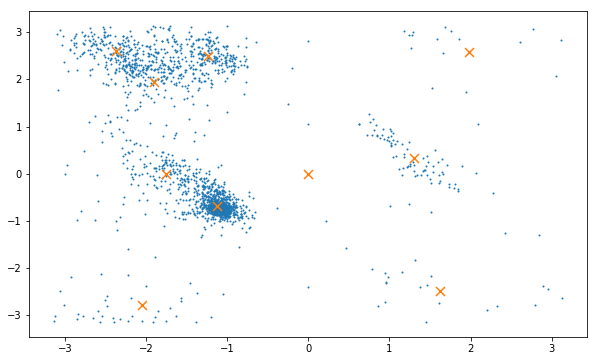

In [135]:
def plot_cluster_centers(data, clusters, x_i, y_i, data_lim=10):
    plt.figure(figsize=(10,6))
    plt.scatter(y_valid[:data_lim][:,:,x_i], y_valid[:data_lim][:,:,y_i], s=1)
    plt.scatter(clusters[:,x_i], clusters[:,y_i], marker='x', s=80)
    
plot_cluster_centers(y_valid, clusters, x_i=0, y_i=1, data_lim=10)
if n_angles == 3:
    plot_cluster_centers(y_valid, clusters, x_i=1, y_i=2, data_lim=10)
    plot_cluster_centers(y_valid, clusters, x_i=0, y_i=2, data_lim=10)

In [136]:
clusters

array([[-6.3210726e-05,  8.0853701e-05],
       [-1.8970349e+00,  1.9483802e+00],
       [-1.1186606e+00, -6.8361336e-01],
       [-2.3636844e+00,  2.6012619e+00],
       [ 1.3089309e+00,  3.3103678e-01],
       [-1.7501278e+00,  1.4927983e-04],
       [-2.0435455e+00, -2.7768259e+00],
       [ 1.6175015e+00, -2.4911966e+00],
       [ 1.9853055e+00,  2.5829377e+00],
       [-1.2392919e+00,  2.4905255e+00]], dtype=float32)

In [137]:
# y_train_labels_ = kmeans.predict(y_train.reshape(-1,3)).reshape(y_train.shape[0], y_train.shape[1]) + 1
y_train_labels_ = np.argmin(scipy.spatial.distance_matrix(y_train.reshape(-1,n_angles), clusters), 
                            axis=1).reshape(y_train.shape[0], y_train.shape[1]) #+ 1
# y_train_labels_[y_train[:,:,0]==0] = n_clusters-1
# y_train_labels_[np.logical_not(mask_)] = 0
print(y_train_labels_.reshape(-1,).shape, np.sum(y_train_labels_ != -1))

# y_valid_labels_ = kmeans.predict(y_valid.reshape(-1,3)).reshape(y_valid.shape[0], y_valid.shape[1]) + 1
y_valid_labels_ = np.argmin(scipy.spatial.distance_matrix(y_valid.reshape(-1,n_angles), clusters), 
                            axis=1).reshape(y_valid.shape[0], y_valid.shape[1]) #+ 1
# y_valid_labels_[y_valid[:,:,0]==0] = n_clusters-1
# y_valid_labels_[np.logical_not(mask_v)] = 0


# ohe = OneHotEncoder(n_values = n_clusters).fit(y_train_labels)
y_train_labels = to_categorical(y_train_labels_, num_classes=n_clusters)
y_valid_labels = to_categorical(y_valid_labels_, num_classes=n_clusters)

y_train_labels.shape, y_valid_labels.shape

(946000,) 946000


((1892, 500, 10), (213, 500, 10))

In [138]:
np.unique(y_train_labels_), np.unique(y_valid_labels_), n_clusters

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 10)

In [139]:
tf.reset_default_graph()

@tf.custom_gradient
def clip_grad_layer(x):
    def grad(dy):
        return tf.clip_by_value(dy, 1e-10, 1e-10)
    return tf.identity(x), grad

clusters_tf = tf.Variable(initial_value=(clusters), dtype=np.float32, trainable=True)
clusters_tf = tf.clip_by_value(clusters_tf, -np.pi, np.pi)
# clusters_tf = clip_grad_layer(clusters_tf)

X = tf.placeholder(tf.float32, [None, max_len, 41], name="X")
input_mask = tf.placeholder(tf.bool, [None, max_len], name="input_mask")
y = tf.placeholder(tf.float32, [None, max_len, n_clusters], name='y')
y_angles = tf.placeholder(tf.float32, [None, max_len, n_angles], name='y_angles')

# mask = tf.not_equal(tf.argmax(y, 2), 0)

# conv1a = tf.layers.conv1d(X, 32, 5, activation=tf.nn.relu, padding='same')
# conv1b = tf.layers.conv1d(conv1a, 32, 5, activation=tf.nn.relu, padding='same')
# conv2a = tf.layers.conv1d(conv1b, 64, 5, activation=tf.nn.relu, padding='same')
# conv2b = tf.layers.conv1d(conv2a, 64, 5, activation=tf.nn.relu, padding='same')
# conv3 = tf.layers.conv1d(tf.concat([conv1b, conv2b], axis=2), 128, 5, activation=tf.nn.relu, padding='same')
# conv3 = tf.layers.dropout(conv3, rate=0.5)

lstm = bidirectional_lstm(X, 1, 32, keep_prob=0.05)

# dense = tf.layers.dense(lstm, 32, activation='relu')
logits = tf.layers.dense(lstm, n_clusters)
logits = tf.layers.dropout(logits, rate=0.05)
y_pred = tf.nn.softmax(logits)

y_masked = tf.boolean_mask(y, input_mask)
logits_masked = tf.boolean_mask(logits, input_mask)
y_pred_masked = tf.boolean_mask(y_pred, input_mask)
y_angles_masked = tf.boolean_mask(y_angles, input_mask)
shape_after_mask = tf.shape(y_masked)
# y_masked = y
# logits_masked = logits
# y_pred_masked = y_pred
rad_pred = tf.einsum('ij,bi->bj', clusters_tf, y_pred_masked)

# Difine the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_masked, logits=logits_masked))

mae_vec = tf.reduce_mean(tf.abs(tf.subtract(rad_pred[:,:], y_angles_masked[:,:])), axis=0)
mae = tf.reduce_mean(tf.abs(tf.subtract(rad_pred[:,:], y_angles_masked[:,:])))

# Define the optimizer operation
learning_rate = tf.placeholder(tf.float32)

optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(mae)
# optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(mae)

# Variables for prediction and accuracy
prediction = tf.argmax(y_pred_masked, 1)
accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_masked, 1)), tf.float32))

# Initialize the variables (they are assigned default values)
init = tf.global_variables_initializer()

n_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
print("Number of parameters:", n_parameters)

/home/mikey/.local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Number of parameters: 19614


In [140]:
batch_size = 32
n_epochs = 500

# Start as session
init_learning_rate = 0.01
with tf.Session() as session:

    # Run the initializer
    session.run(init)

    # Training cycle
    for epoch in range(n_epochs):
        print("Epoch:", epoch)
        train_loss = []
        for b in range(0, x_train.shape[0], batch_size):
            _, loss_value, mae_ = session.run([optimizer, loss, mae_vec], feed_dict={X: x_train[b:b+batch_size],
                                                                      y: y_train_labels[b:b+batch_size],
                                                                      y_angles: y_train[b:b+batch_size],
                                                                      learning_rate: init_learning_rate,
                                                                    input_mask: mask_[b:b+batch_size]})
            train_loss.append(mae_)
        
        (validation_accuracy, mae_, pred_, 
         clusters_, y_pred_masked_, rad_pred_) = session.run([accuracy, mae_vec, prediction, 
                                                              clusters_tf, y_pred_masked, rad_pred], 
                                                              feed_dict={X: x_valid, y: y_valid_labels, 
                                                                         y_angles:y_valid,
                                                                        input_mask: mask_v})
#         print("val. loss = %f, val_acc = %f" % (loss_value, validation_accuracy))    
        print("Train MAE = %f" % (np.mean(train_loss)))
        print("Val. MAE", mae_, np.mean(mae_))
        print(collections.Counter(pred_))
#         print(np.mean(y_pred_masked_, axis=0)) # prob. dist mean over clusters
#         print(np.max(y_pred_masked_, axis=0)) # prob. dist max over clusters
        print(init_learning_rate)
#         print(clusters_)
        
        train_loss = []
        if (epoch + 1) % 10 == 0:
            print("Adjusting learning rate")
            init_learning_rate = init_learning_rate / 1.1
    
    print("Optimization done")

    # Calculate training accuracy
    train_accuracy_value, pred_train, shape_after_mask_ = session.run([accuracy, prediction, shape_after_mask], 
                                                                      feed_dict={X: x_train, y: y_train_labels,
                                                                                y_angles: y_train,
                                                                                input_mask: mask_})
    print("Train accuracy:", train_accuracy_value)
    print("Shape after mask:", shape_after_mask_)
    
    # Calculate test accuracy
    test_accuracy_value, pred_test, shape_after_mask_ = session.run([accuracy, prediction, shape_after_mask], 
                                                                    feed_dict={X: x_valid, y: y_valid_labels,
                                                                              y_angles: y_valid,
                                                                              input_mask: mask_v})
    print("Test accuracy:", test_accuracy_value)
    print("Shape after mask:", shape_after_mask_)

Epoch: 0
Train MAE = 1.196905
Val. MAE [0.9292578 1.4139432] 1.1716005
Counter({6: 15995, 1: 7421, 5: 6289, 9: 2584, 3: 2180, 2: 2145, 0: 754, 4: 133, 7: 131, 8: 2})
0.01
Epoch: 1
Train MAE = 1.144119
Val. MAE [0.82801217 1.4130002 ] 1.1205062
Counter({6: 21971, 1: 6728, 5: 5401, 3: 1851, 9: 847, 2: 770, 0: 63, 7: 3})
0.01
Epoch: 2
Train MAE = 1.096016
Val. MAE [0.73951745 1.4114399 ] 1.0754787
Counter({6: 28125, 1: 4343, 5: 3558, 3: 1159, 2: 247, 9: 195, 0: 7})
0.01
Epoch: 3
Train MAE = 1.056194
Val. MAE [0.67285275 1.4113127 ] 1.0420828
Counter({6: 31966, 1: 2552, 5: 2389, 3: 611, 9: 67, 2: 49})
0.01
Epoch: 4
Train MAE = 1.029379
Val. MAE [0.6362517 1.4080678] 1.0221598
Counter({6: 34433, 5: 1522, 1: 1356, 3: 284, 2: 20, 9: 19})
0.01
Epoch: 5
Train MAE = 1.015341
Val. MAE [0.6186561 1.4055191] 1.0120876
Counter({6: 35782, 5: 1131, 1: 543, 3: 163, 2: 10, 9: 5})
0.01
Epoch: 6
Train MAE = 1.008400
Val. MAE [0.6111246 1.4037598] 1.0074422
Counter({6: 36405, 5: 766, 1: 370, 3: 88, 2: 3, 9

Train MAE = 0.994757
Val. MAE [0.60051465 1.3933843 ] 0.9969495
Counter({6: 37614, 5: 17, 1: 3})
0.005644739300537772
Epoch: 68
Train MAE = 0.994765
Val. MAE [0.6010309 1.3924474] 0.99673915
Counter({6: 37612, 5: 18, 1: 4})
0.005644739300537772
Epoch: 69
Train MAE = 0.994778
Val. MAE [0.6004809 1.3931544] 0.99681765
Counter({6: 37607, 5: 23, 1: 3, 2: 1})
0.005644739300537772
Adjusting learning rate
Epoch: 70
Train MAE = 0.994794
Val. MAE [0.60043496 1.392231  ] 0.996333
Counter({6: 37626, 5: 7, 1: 1})
0.005131581182307065
Epoch: 71
Train MAE = 0.994712
Val. MAE [0.6002668 1.3933066] 0.9967867
Counter({6: 37614, 5: 17, 1: 3})
0.005131581182307065
Epoch: 72
Train MAE = 0.994581
Val. MAE [0.60057557 1.393692  ] 0.9971338
Counter({6: 37618, 5: 14, 1: 2})
0.005131581182307065
Epoch: 73
Train MAE = 0.994624
Val. MAE [0.6003585 1.3925569] 0.9964577
Counter({6: 37612, 5: 20, 3: 2})
0.005131581182307065
Epoch: 74
Train MAE = 0.994633
Val. MAE [0.59993285 1.3922703 ] 0.9961016
Counter({6: 37615,

Train MAE = 0.993768
Val. MAE [0.59983474 1.3920152 ] 0.99592495
Counter({6: 37623, 5: 9, 1: 2})
0.0028966437973668773
Epoch: 131
Train MAE = 0.993713
Val. MAE [0.5997774 1.3926945] 0.99623597
Counter({6: 37614, 5: 14, 1: 6})
0.0028966437973668773
Epoch: 132
Train MAE = 0.994046
Val. MAE [0.600398  1.3918833] 0.9961406
Counter({6: 37622, 5: 10, 1: 2})
0.0028966437973668773
Epoch: 133
Train MAE = 0.993958
Val. MAE [0.60018724 1.3913326 ] 0.99575996
Counter({6: 37617, 5: 12, 1: 5})
0.0028966437973668773
Epoch: 134
Train MAE = 0.993696
Val. MAE [0.5999577 1.3918496] 0.9959037
Counter({6: 37627, 5: 7})
0.0028966437973668773
Epoch: 135
Train MAE = 0.993841
Val. MAE [0.59965336 1.3912531 ] 0.99545324
Counter({6: 37623, 5: 8, 1: 3})
0.0028966437973668773
Epoch: 136
Train MAE = 0.993839
Val. MAE [0.5994831 1.391921 ] 0.995702
Counter({6: 37620, 5: 13, 1: 1})
0.0028966437973668773
Epoch: 137
Train MAE = 0.993847
Val. MAE [0.5992948 1.3925006] 0.9958977
Counter({6: 37622, 5: 12})
0.0028966437973

Train MAE = 0.993419
Val. MAE [0.599425  1.3916241] 0.9955245
Counter({6: 37625, 5: 8, 1: 1})
0.0016350799082655782
Epoch: 194
Train MAE = 0.993587
Val. MAE [0.5989588 1.3914022] 0.9951805
Counter({6: 37617, 5: 17})
0.0016350799082655782
Epoch: 195
Train MAE = 0.993450
Val. MAE [0.6001947 1.3916706] 0.99593264
Counter({6: 37618, 5: 14, 1: 2})
0.0016350799082655782
Epoch: 196
Train MAE = 0.993432
Val. MAE [0.59994596 1.3915356 ] 0.9957408
Counter({6: 37620, 5: 13, 1: 1})
0.0016350799082655782
Epoch: 197
Train MAE = 0.993475
Val. MAE [0.5996477 1.3911002] 0.99537396
Counter({6: 37618, 5: 13, 1: 3})
0.0016350799082655782
Epoch: 198
Train MAE = 0.993361
Val. MAE [0.599087  1.3914481] 0.99526757
Counter({6: 37620, 5: 14})
0.0016350799082655782
Epoch: 199
Train MAE = 0.993335
Val. MAE [0.59960616 1.3918306 ] 0.99571836
Counter({6: 37613, 5: 20, 1: 1})
0.0016350799082655782
Adjusting learning rate
Epoch: 200
Train MAE = 0.993359
Val. MAE [0.5992839 1.3908149] 0.99504936
Counter({6: 37622, 5: 

KeyboardInterrupt: 

In [22]:
np.min(rad_pred_)

-0.22896507

Organize model modes:
- predict angles through regression (tanh, *pi)
- predict clusters and optimize for crossentropy
- predict clusters and optimize for MAE
- predict clusters as vectors and optimize for MAE

In [46]:
np.mean(np.abs(clusters_[pred_] - y_valid[mask_v])

array([[0.853431  , 0.29503512, 3.1235397 ],
       [0.57627773, 0.61460125, 3.1102312 ],
       [0.13828385, 0.36523938, 2.9928179 ],
       ...,
       [0.1008271 , 3.0192895 , 3.137029  ],
       [0.251745  , 3.2153685 , 3.141288  ],
       [0.19128823, 2.8222716 , 0.48199463]], dtype=float32)

resnet CNN filter_length = 15 (with 5 it didn't change much either)

*Rad angles, 10 not trainable clusters: 0.59

*Rad angles, 10 trainable clusters, no clipping: MAE [0.43384644 0.721744  ] 0.5777952

*Rad angles, 50 trainable clusters, no clipping: 
Train MAE = 0.545068
Val. MAE [0.43777448 0.7208223 ] 0.5792984